# READ wine.csv (30%)

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [16]:
names = ['Type', 'Alcohol','Malic_acid','Ash','Alcalinity_of_ash', 'Magnesium','Total_phenols','Flavanoids', 'Nonflavanoid_phenols', 'Proanthocyanins', 'Color_intensity', 'Hue','OD280/OD315_of_diluted_wines', 'Proline']
data = pd.read_csv('Wine.csv', names = names)
data.head()

,Type,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280/OD315_of_diluted_wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


## Split data

In [0]:
#Writing data into dictionay
wine = {}
for types in range(1,4):
  wine[types] = data[data.Type == types].values

### 1. Split through

```
sklearn.model_selection  train_test_split
```



In [0]:
def ran_split(wine: dict, xtrain: list, xtest: list):
  for types in range(1,4):
    train, test = train_test_split(wine[types], test_size = 18, shuffle =True)
    xtrain.extend(train)
    xtest.extend(test)
  xtrain = np.array(xtrain)
  xtest = np.array(xtest)
  return xtrain, xtest

In [0]:
xtrain, xtest = ran_split(wine, [], [])

In [57]:
xtrain.shape

(124, 14)

In [58]:
xtest.shape

(54, 14)

### 2. Split by hand

In [0]:
def ran_split2(wine: dict, xtrain: list, xtest: list):
  for types in range(1,4):
    seeds = np.random.choice(range(len(wine[types])),size = 18, replace= False)
    for i in range(len(wine[types])):
        if (i in seeds):
          xtest.extend(wine[types][i].reshape(1,-1)) 
        else:
          xtrain.extend(wine[types][i].reshape(1,-1))

  xtrain = np.array(xtrain)
  xtest = np.array(xtest)
  return xtrain, xtest

In [0]:
xtrain2, xtest2 = ran_split2(wine, [], [])

In [12]:
xtrain2.shape

(124, 14)

In [13]:
xtest2.shape

(54, 14)

## Save train.csv and test.csv

In [0]:
Train = pd.DataFrame(xtrain,columns = ['Type', 'Alcohol','Malic_acid','Ash','Alcalinity_of_ash', 'Magnesium','Total_phenols','Flavanoids', 'Nonflavanoid_phenols', 'Proanthocyanins', 'Color_intensity', 'Hue','OD280/OD315_of_diluted_wines', 'Proline'])
Test = pd.DataFrame(xtest, columns = ['Type', 'Alcohol','Malic_acid','Ash','Alcalinity_of_ash', 'Magnesium','Total_phenols','Flavanoids', 'Nonflavanoid_phenols', 'Proanthocyanins', 'Color_intensity', 'Hue','OD280/OD315_of_diluted_wines', 'Proline'] )

Train.to_csv('Train.csv', index = False)
Test.to_csv('Test.csv', index = False)

# Evaluate the Posterior Probabilities and Camparing with MAP (50%)

In [0]:
def modify_data(train, test):
  ytrain = train.T[0]
  xtrain = train[:,1:]
  ytest = test.T[0]
  xtest = test[:,1:]
  return xtrain, xtest, ytrain, ytest

## Evaluate Prior distribution

$$ p(Class 1) = \frac{C1}{C1+C2+C3} $$
$$ p(Class 2) = \frac{C2}{C1+C2+C3} $$
$$ p(Class 3) = \frac{C3}{C1+C2+C3} $$


In [0]:
def cal_prior(train): 
  prior_1 = len(train[ytrain == 1])/ len(train)
  prior_2 = len(train[ytrain == 2])/ len(train)
  prior_3 = len(train[ytrain == 3])/ len(train)
  return prior_1, prior_2, prior_3

In [62]:
xtrain, xtest, ytrain, ytest = modify_data(xtrain, xtest)
prior_1, prior_2, prior_3 = cal_prior(ytrain)
print(prior_1, prior_2, prior_3)

0.33064516129032256 0.4274193548387097 0.24193548387096775


## Learning likelihood function 

Using <font color=#0099ff face="Times">***probablity densinty distribution***</font> of <font color=#0099ff face="Times"> ***Guassian Distribution*** </font> to learn likelihooh function of each class. 

Because there are 13 features in this case ,we use  <font color=#FF0000 face="Times" size = 5>  ***Multivariate Guassian Distribution*** </font>

<br>$$P(x;\mu, \Sigma) =  \frac{1}{( 2\pi )^{D/2} \times |\Sigma| ^{1/2}} \times \exp (-\frac {1}{2} \times {(x-\mu)^{T}} \cdot \Sigma^{-1}  \cdot (x - \mu))  $$      
<br>
* $ D$ : dimension of $x$ (features)

* $ \mu = \frac{1}{n} {\sum_1^n}x$

* $ \Sigma = Coveriance(x),　size = (D,D)$






In [0]:
## sampling data with multivariate guassian distribution
def multivariate_guassian(x, d, mean, sigma):
  x = x.reshape(13,1)
  exp = (np.exp((-1/2) * (x-mean).T @ np.linalg.inv(sigma) @ (x - mean))).item()
  return (1 / (2 * np.pi)** (d/2) ) * np.sqrt(np.linalg.det(sigma)) *exp

### To learning likelihood function of each group, we have to estimate their parameters $\mu$ and $\Sigma$

In [0]:
def parameters(x: np.array):
  mean = (np.sum(x, axis = 0) / len(x)).reshape(13,1)
  cov = np.cov(x.T)
  return mean, cov

#### $\mu$ and $\Sigma$ of Class 1

In [0]:
mean, cov = parameters(xtrain[:41,:])
print(mean)
print(cov)

#### $\mu$ and $\Sigma$ of Class 2

In [51]:
mean, cov = parameters(xtrain[41:94,:])
print(mean)
print(cov)

[[1.22956604e+01]
 [1.82547170e+00]
 [2.22698113e+00]
 [1.99924528e+01]
 [9.23773585e+01]
 [2.09641509e+00]
 [1.91603774e+00]
 [3.77924528e-01]
 [1.51698113e+00]
 [3.09358491e+00]
 [1.07086792e+00]
 [2.66981132e+00]
 [5.16358491e+02]]
[[ 2.87336575e-01  3.64068940e-02 -3.53075835e-02 -6.24756894e-02
  -5.50446299e-01  3.94952830e-03  4.69209361e-02 -1.19784107e-02
  -1.38075835e-02  1.79988933e-01 -1.77473149e-02 -5.99891147e-03
  -9.44952830e-01]
 [ 3.64068940e-02  8.73159869e-01  2.18822206e-02  4.84195936e-01
  -1.36306604e+00 -5.01319303e-02 -1.93682874e-02  2.03673440e-02
   1.09552975e-02 -1.24006531e-01 -7.99098403e-02  2.77914369e-02
  -1.91958454e+01]
 [-3.53075835e-02  2.18822206e-02  8.43137881e-02  5.92649855e-01
   3.85968795e-01  6.20464441e-05  2.66185776e-02  1.09589985e-02
   2.51464804e-02 -5.50243106e-03  3.28113208e-03  6.81288099e-03
  -5.85820029e-01]
 [-6.24756894e-02  4.84195936e-01  5.92649855e-01  9.81724964e+00
  -1.08297896e+01 -1.76044993e-02  3.29719521e-0

#### $\mu$ and $\Sigma$ of Class 3

In [52]:
mean, cov = parameters(xtrain[94:,:])
print(mean)
print(cov)

[[1.31180000e+01]
 [3.47566667e+00]
 [2.46633333e+00]
 [2.19000000e+01]
 [1.00533333e+02]
 [1.71033333e+00]
 [7.73000000e-01]
 [4.67666667e-01]
 [1.17500000e+00]
 [7.47800000e+00]
 [6.90333333e-01]
 [1.71600000e+00]
 [6.54666667e+02]]
[[ 1.79299310e-01  1.71393103e-02  1.74820690e-02  9.35862069e-02
   5.05241379e-01  3.08317241e-02  2.46027586e-02 -9.15655172e-03
   4.81655172e-02  2.77437241e-01 -1.86137931e-03  2.17951724e-02
  -5.15586207e+00]
 [ 1.71393103e-02  9.73942644e-01  2.59732184e-02  3.55758621e-01
  -1.04140230e+00  4.32528736e-04 -2.55003448e-02  5.31367816e-03
  -7.33810345e-02 -5.55998621e-01  2.21187356e-02 -4.55317241e-02
  -1.01618391e+01]
 [ 1.74820690e-02  2.59732184e-02  3.94722989e-02  3.33413793e-01
   2.18919540e-01  1.90909195e-02  8.89068966e-03 -2.11919540e-03
  -3.88793103e-03  5.37862069e-03  6.17712644e-03  1.53400000e-02
  -6.40643678e+00]
 [ 9.35862069e-02  3.55758621e-01  3.33413793e-01  4.43793103e+00
   4.08965517e+00  1.98482759e-01  1.08758621e-0

## Calculate Posterior and the error rate or accuracy rate of the MAP detector

$$Posterior( P(C1|x) ) = \frac{P(x|C1) \times P(c1)}{𝑃 (𝑥|𝐶1)\times𝑃(𝐶1) + 𝑃 (𝑥|𝐶2)\times 𝑃(𝐶2) + P(x|c3)\times P(C3)} $$

<br>



*   Likelihood function: $  P(x|C1), P(x|C2), P(x|C3) $

*   Prior: $ P(C1), P(C2), P(C3) $



random select from data

In [0]:
train, test = ran_split(wine,[], [])
xtrain, xtest, ytrain, ytest = modify_data(train, test)
prior_1, prior_2, prior_3 = cal_prior(ytrain)

class1_x = xtrain[:41,:]
class2_x = xtrain[41:94,:]
class3_x = xtrain[94:,:]

mean, cov = parameters(class1_x)
mean2, cov2 = parameters(class2_x)
mean3, cov3 = parameters(class3_x)

In [108]:
acc_seeds = 0
clas = 0

for i in range(len(xtest)):
  t = xtest[i]

  posterior_1 = (multivariate_guassian(t,13,mean,cov)*prior_1) / (multivariate_guassian(t,13,mean,cov)*prior_1 + multivariate_guassian(t,13,mean2,cov2)*prior_2 + multivariate_guassian(t,13,mean3,cov3)*prior_3)
  posterior_2 = (multivariate_guassian(t,13,mean2,cov2)*prior_2) / (multivariate_guassian(t,13,mean,cov)*prior_1 + multivariate_guassian(t,13,mean2,cov2)*prior_2 + multivariate_guassian(t,13,mean3,cov3)*prior_3)
  posterior_3 = (multivariate_guassian(t,13,mean3,cov3)*prior_3) / (multivariate_guassian(t,13,mean,cov)*prior_1 + multivariate_guassian(t,13,mean2,cov2)*prior_2 + multivariate_guassian(t,13,mean3,cov3)*prior_3)

  good = max(posterior_1, posterior_2, posterior_3)


  if (good == posterior_1):
    clas = 1
  elif (good == posterior_2):
    clas = 2
  else:
    clas = 3
  print('%d. is belong to class %d with posterior = %f \t\t posterior of each class = %f, %f, %f' % (i+1,clas,good, posterior_1, posterior_2, posterior_3) )

  
  if (clas == ytest[i]):
    acc_seeds += 1
    print('\t Correctly Classify\n\n')

1. is belong to class 1 with posterior = 0.864144 		 posterior of each class = 0.864144, 0.135856, 0.000000
	 Correctly Classify


2. is belong to class 1 with posterior = 0.999923 		 posterior of each class = 0.999923, 0.000077, 0.000000
	 Correctly Classify


3. is belong to class 2 with posterior = 0.760671 		 posterior of each class = 0.239329, 0.760671, 0.000000
4. is belong to class 1 with posterior = 1.000000 		 posterior of each class = 1.000000, 0.000000, 0.000000
	 Correctly Classify


5. is belong to class 1 with posterior = 1.000000 		 posterior of each class = 1.000000, 0.000000, 0.000000
	 Correctly Classify


6. is belong to class 1 with posterior = 1.000000 		 posterior of each class = 1.000000, 0.000000, 0.000000
	 Correctly Classify


7. is belong to class 1 with posterior = 1.000000 		 posterior of each class = 1.000000, 0.000000, 0.000000
	 Correctly Classify


8. is belong to class 1 with posterior = 1.000000 		 posterior of each class = 1.000000, 0.000000, 0.00000

In [109]:
print('Accuracy Rate = %f' % (acc_seeds/len(ytest)))

Accuracy Rate = 0.962963


# Discussion Characteristics and Plot the Visualized Result of Testing Data(20%)

## 2-Dim PCA Visualization

In [0]:
from sklearn.decomposition import PCA

In [0]:
pca = PCA(n_components=2 )
pca.fit(xtest)

new_xtest = pca.transform(xtest)
new_xtest

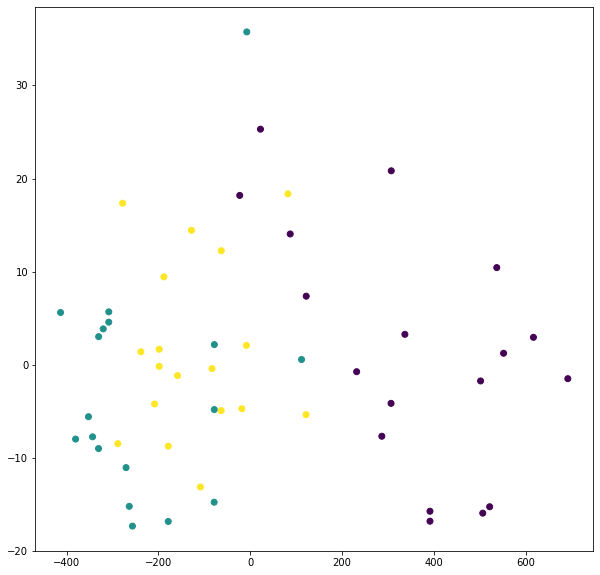

In [123]:
plt.figure(figsize=(10,10))
plt.scatter(new_xtest[:,0], new_xtest[:,1], c=ytest, marker='o')

## 3-Dim PCA Visualization

In [0]:
from mpl_toolkits.mplot3d import Axes3D

In [134]:
pca3d = PCA(n_components=3)
pca3d.fit(xtest)
new_xtest3d = pca3d.transform(xtest)
new_xtest3d

array([[ 1.21975857e+02,  7.35478611e+00, -3.31774815e+00],
       [ 5.01864750e+02, -1.75244157e+00,  1.43544116e+00],
       [-2.28669273e+01,  1.81857141e+01,  5.31095775e-01],
       [ 5.37096356e+02,  1.04285077e+01,  1.70592623e-01],
       [ 6.16970172e+02,  2.93575405e+00,  6.49998648e-01],
       [ 5.21603652e+02, -1.52716609e+01,  9.10159526e-02],
       [ 5.06588613e+02, -1.59587664e+01,  4.20566330e-01],
       [ 3.07270623e+02,  2.08296011e+01, -2.77285946e+00],
       [ 5.51926915e+02,  1.22434063e+00,  9.33013301e-01],
       [ 8.71013703e+01,  1.40409870e+01, -3.55322121e+00],
       [ 3.91582997e+02, -1.68242199e+01, -5.11926180e+00],
       [ 3.91597275e+02, -1.57559551e+01, -3.54886228e+00],
       [ 3.06786791e+02, -4.16133078e+00, -1.65384048e+00],
       [ 2.23066184e+01,  2.53024088e+01, -3.63948072e+00],
       [ 3.36916148e+02,  3.25645659e+00,  4.65349333e-01],
       [ 2.86718803e+02, -7.69574161e+00, -1.11615444e+00],
       [ 2.31830417e+02, -7.59398849e-01

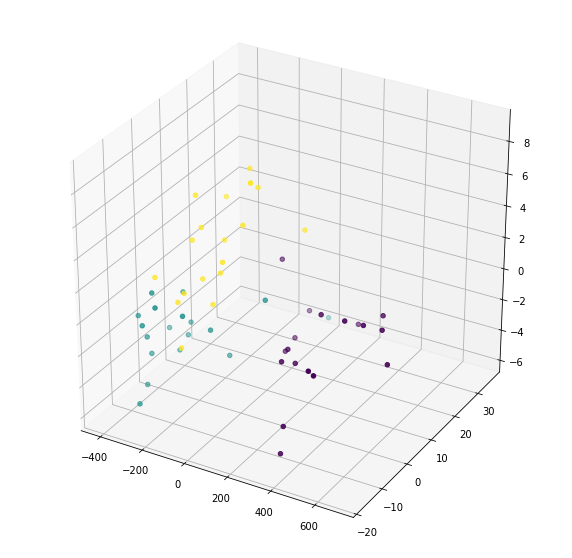

In [142]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(new_xtest3d[:,0], new_xtest3d[:,1], zs = new_xtest3d[:,2], c=ytest)